# Intermittency Analysis
- Figure 6

In [5]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# from calcium_utils import *

from scipy.sparse import csgraph
from meshparty import skeleton_io
from scipy.sparse.csgraph import shortest_path

# from scipy.stats import pearsonr
# from scipy.stats import ranksums
# from scipy.stats import chi2_contingency
# from scipy.stats import linregress
# from scipy.stats import percentileofscore

%matplotlib inline

## Download data

In [11]:
!bash downloadCalciumTraces.sh # Functional activity
!bash downloadSkeletons.sh # Skeletons

Downloading...
From: https://drive.google.com/uc?id=1S2qE6-oNP_KMvkobRxswkH0DqCJDbPnu
To: /usr/people/jabae/github/MicronsBinder/notebooks/multiscale/function/data/calcium_trace.tgz
47.4MB [00:00, 75.9MB/s]
~/github/MicronsBinder/notebooks/multiscale/function/data ~/github/MicronsBinder/notebooks/multiscale/function
~/github/MicronsBinder/notebooks/multiscale/function
Downloading...
From: https://drive.google.com/uc?id=1Tpa-p7rwOZ65rIwDPbm4famUFtqhbqOK
To: /usr/people/jabae/github/MicronsBinder/notebooks/multiscale/function/data/smoothed_skeletons_v185.tgz
493MB [00:06, 77.0MB/s] 
~/github/MicronsBinder/notebooks/multiscale/function/data ~/github/MicronsBinder/notebooks/multiscale/function
~/github/MicronsBinder/notebooks/multiscale/function


## Functions

In [33]:
def distance(x, y):
    
    return np.sqrt(np.sum((x-y)**2, axis=1))


def str2coord(str_coord, dtype="int"):
    
    l = str_coord[1:-1].split(" ")
    coord = []
    for j in range(len(l)):
        if l[j] != "":
            if dtype == "int": 
                coord.append(int(l[j]))
            elif dtype == "float":
                coord.append(float(l[j]))
    
    coord = np.array(coord)
    
    return coord

## All PyC

In [13]:
cell_info = pd.read_csv("data/cell_info.csv")

pyc_list = cell_info["segment_id"]
n_pyc = pyc_list.shape[0]

cell_info

,segment_id,soma_loc
0,648518346349491311,[314.028 159.94 77.28 ]
1,648518346349492130,[291.484 145.484 80.96 ]
2,648518346349492197,[270.948 158.088 86.24 ]
3,648518346349492682,[461.372 212.624 27.64 ]
4,648518346349493472,[431.864 156.576 85.72 ]
...,...,...
358,648518346349540048,[349.132 163.492 11.48 ]
359,648518346349540051,[444.892 247.424 47.48 ]
360,648518346349540053,[446.104 253.936 18.32 ]
361,648518346349540055,[340.468 248.332 23.4 ]


## PyC with functional data

In [14]:
cell_info_func = pd.read_csv("data/cell_functional_info.csv")

pyc_func_list = np.array(cell_info_func["segment_id"])
scan_list = np.array(cell_info_func["scan"])
n_func = pyc_func_list.shape[0]

osi_p = np.array(cell_info_func["osi_p"])
dsi_p = np.array(cell_info_func["dsi_p"])

tune_os_idx = osi_p<0.05
tune_ds_idx = dsi_p<0.05
tune_all_idx = tune_os_idx + tune_ds_idx

seg_id_os = pyc_func_list[tune_os_idx]
seg_id_ds = pyc_func_list[tune_ds_idx]
seg_id_tuned = pyc_func_list[tune_all_idx]

cell_info_func

,segment_id,scan,osi,osi_p,dsi,dsi_p
0,648518346349539895,1,1.399790,0.0093,0.360205,0.9048
1,648518346349537860,1,1.768346,0.0000,0.439699,0.6045
2,648518346349538440,1,1.375106,0.0027,0.263231,0.9977
3,648518346349538527,1,1.021334,0.0285,0.972555,0.9738
4,648518346349538209,1,1.863632,0.0000,0.100173,0.9697
...,...,...,...,...,...,...
107,648518346349537741,5,1.266736,0.0591,0.528219,0.9734
108,648518346349537901,5,1.163586,0.1107,1.162096,0.1381
109,648518346349538001,5,1.352991,0.0468,1.350374,0.0465
110,648518346349538251,5,1.436740,0.0149,1.399342,0.0315


In [6]:
f_rawtrace = open("data/trace_raw.pkl","rb")
RawTrace = pickle.load(f_rawtrace)
f_rawtrace.close()

f_trace = open("data/trace.pkl", "rb")
Trace = pickle.load(f_trace)
f_trace.close()

f_spike = open("data/spike.pkl", "rb")
Spike = pickle.load(f_spike)
f_spike.close()

f_stim_lab = open("data/stimulus_label.pkl", "rb")
StimulusLabel = pickle.load(f_stim_lab)
f_stim_lab.close()

## PyC - PyC subgraph
- Pyramidal cells that have cell bodies in our volume.
- Connections among pyramidal cells

In [7]:
synapse_pyc_df = pd.read_csv("data/pyc_pyc_subgraph.csv")
synapse_pyc_df

,segmentation,id,valid,pre_pt_position,pre_pt_supervoxel_id,pre_pt_root_id,ctr_pt_position,post_pt_position,post_pt_supervoxel_id,post_pt_root_id,size,spine_vol,exclude_conn
0,185,1484,1,[91332 57836 1584],97170491155950710,648518346349539437,[91369 57798 1582],[91332 57748 1584],97170491155951077,648518346349531254,798,0.133004,0
1,185,2254,1,[64762 45414 711],89838917557174822,648518346349537978,[64742 45419 708],[64720 45430 708],89838917557173796,648518346349537300,129,0.016346,0
2,185,3785,1,[69646 63086 721],91264984138384361,648518346349533058,[69604 63106 721],[69558 63120 721],90983509161691227,648518346349538715,62,0.020969,0
3,185,3863,1,[66776 39946 1138],90396382837344883,648518346349539333,[66750 39982 1139],[66722 39990 1139],90396382837366381,648518346349539806,62,0.018033,0
4,185,4062,1,[89112 48970 2154],96597662777759466,648518346349523975,[89162 48958 2154],[89198 48936 2154],96597662777759456,648518346349537716,62,0.008805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963,185,3546372,1,[76660 54312 1086],92945050790541263,648518346349539803,[76699 54305 1090],[76708 54262 1088],92943951278915237,648518346349538239,130,0.044672,0
1964,185,3548009,1,[94662 61228 453],98018175966264919,648518346349531254,[94712 61234 453],[94728 61228 453],98018175966265405,648518346349534360,61,0.023423,0
1965,185,3549101,1,[110936 59500 1362],102520706146780107,648518346349537716,[110994 59494 1363],[111032 59498 1362],102520706146780799,648518346349539896,61,0.016121,0
1966,185,3549680,1,[89680 50944 1475],96599840326171296,648518346349539437,[89706 50906 1474],[89718 50884 1473],96599840326170447,648518346349539781,61,0.021125,0


## Compute dendrite length
- Unit: [$\mu$m]

In [17]:
d_skel = "data/smoothed_skeletons_v185/"

# Calculate dendrite length
dendrite_len = np.zeros((n_pyc,)) # In microns
for i in range(n_pyc):
    
    seg_id = pyc_list[i]
    seg_lab = np.load(d_skel+str(seg_id)+"_skeleton_label.npy")
    seg_skel = skeleton_io.read_skeleton_h5(d_skel+str(seg_id)+"_skeleton.h5")
    
    g = seg_skel.csgraph
    dend_idx = np.where((seg_lab==2)+(seg_lab==3)+(seg_lab==4))[0]
    g = g[dend_idx][:,dend_idx]
    
    dendrite_len[i] = np.sum(g)/1000
    
# Manual correction
seg_id = 648518346349538414
idx = np.where(pyc_list==seg_id)
seg_lab = np.load(d_skel+str(seg_id)+"_skeleton_label.npy")
seg_skel = skeleton_io.read_skeleton_h5(d_skel+str(seg_id)+"_skeleton.h5")

g = seg_skel.csgraph
dend_idx = np.where((seg_lab==2)+(seg_lab==5))[0]
g = g[dend_idx][:,dend_idx]

dendrite_len[idx] = np.sum(g)/1000

In [18]:
dendrite_len_func = np.zeros(n_func)
for i in range(n_func):
    seg_id = pyc_func_list[i]
    dendrite_len_func[i] = dendrite_len[pyc_list==seg_id] 

## Compute in-connection density

In [19]:
pre_id_all = synapse_pyc_df["pre_pt_root_id"]
post_id_all = synapse_pyc_df["post_pt_root_id"]
real_synapse = np.zeros((pre_id_all.shape[0],2), dtype=np.uint64)
real_synapse[:,0] = pre_id_all
real_synapse[:,1] = post_id_all
real_connection = np.unique(real_synapse, axis=0)

In [23]:
# In/out degree
# Computing only for cells with functional data
insyn_deg = np.zeros((n_func)) # In-synapse degree
inconn_deg = np.zeros((n_func)) # In-connection degree
outsyn_deg = np.zeros((n_func)) # Out-synapse degree
outconn_deg = np.zeros((n_func)) # Out-connection degree

for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    
    outsyn_deg[i] = np.sum(real_synapse[:,0]==seg_id)
    insyn_deg[i] = np.sum(real_synapse[:,1]==seg_id)
    
    outconn_deg[i] = np.sum(real_connection[:,0]==seg_id)
    inconn_deg[i] = np.sum(real_connection[:,1]==seg_id)

In [24]:
# In-connection density
inconn_density = inconn_deg/dendrite_len_func

## Compute total in-synapse density

- `data/pyc_all_synapse.csv`: All synapses involving pyramidal cells. i.e. All incoming synapses to pyramidal cells and all outgoing synapses from pyramidal cells. 

In [25]:
synapse_all_pyc_df = pd.read_csv("data/pyc_all_synapse.csv")
synapse_all_pyc_df

,Unnamed: 0,id,valid,pre_pt_position,pre_pt_supervoxel_id,pre_pt_root_id,ctr_pt_position,post_pt_position,post_pt_supervoxel_id,post_pt_root_id,size
0,798380,1,True,[54560 41084 1899],87019808398267921,648518346344505885,[54623 41105 1898],[54606 41142 1899],87019808398265812,648518346349537984,127.0
1,884354,2,True,[111618 68848 170],102812038073418275,648518346342561389,[111617 68901 172],[111536 68888 170],102530563096718550,648518346349537380,153.0
2,248,5,True,[99656 73460 1441],99438779349084007,648518346341408101,[99676 73497 1440],[99584 73470 1439],99438779349083054,648518346349507351,112.0
3,10178,6,True,[56020 42658 1566],87302374296654983,648518346349533058,[56024 42669 1562],[55970 42702 1566],87302374296657562,648518346342805464,714.0
4,295400,22,True,[76020 42954 713],92931843766107917,648518346347971764,[76047 42915 709],[75996 42872 712],92931843766107136,648518346349538718,608.0
...,...,...,...,...,...,...,...,...,...,...,...
902304,169242,3556630,True,[78330 55234 2100],93508035103698987,648518346346314910,[78320 55200 2101],[78314 55176 2101],93508035103699504,648518346349538378,61.0
902305,692081,3556632,True,[70760 56782 905],91539870635267659,648518346342798934,[70750 56788 902],[70702 56780 904],91539870635267469,648518346349539856,224.0
902306,538993,3556638,True,[59556 42132 747],88428244138743851,648518346342799568,[59582 42104 747],[59610 42086 747],88428244138743660,648518346349539781,61.0
902307,145593,3556639,True,[59506 42486 778],88428248433693199,648518346345304931,[59570 42510 777],[59606 42526 778],88428248433693419,648518346349538387,61.0


In [34]:
str2coord(cell_info["soma_loc"][0], "float")

array([314.028, 159.94 ,  77.28 ])

In [36]:
pyc_soma_loc = np.zeros((n_pyc, 3))
for i in range(n_pyc):
    pyc_soma_loc[i,:] = str2coord(cell_info["soma_loc"][i], dtype="float")

In [37]:
post_id_all = np.array(synapse_all_pyc_df["post_pt_root_id"])
post_idx = np.where(np.isin(post_id_all, pyc_list))[0]

synapse_post_pyc_df = synapse_all_pyc_df.iloc[post_idx]

post_centroids = np.zeros((post_idx.shape[0],3))
for i in range(post_idx.shape[0]):
    post_centroids[i,:] = str2coord(synapse_post_pyc_df.iloc[i]["ctr_pt_position"])

post_id_list = np.array(synapse_post_pyc_df["post_pt_root_id"])
post_soma_loc = np.zeros(post_centroids.shape)
for i in range(post_id_list.shape[0]):  
    post_soma_loc[i,:] = pyc_soma_loc[pyc_list==post_id_list[i],:]
    
res = np.array([0.004, 0.004, 0.04])
post_centroids = post_centroids*res

# Filter out synapses within 15 um from the soma to remove perisomatic synapses.
d_post = distance(post_centroids, post_soma_loc)
valid = (d_post>15)

# All incoming synapses to pyramidal cells without perisomatic synapses.
synapse_post_pyc_df = synapse_post_pyc_df.iloc[valid]
synapse_post_pyc_df

,Unnamed: 0,id,valid,pre_pt_position,pre_pt_supervoxel_id,pre_pt_root_id,ctr_pt_position,post_pt_position,post_pt_supervoxel_id,post_pt_root_id,size
0,798380,1,True,[54560 41084 1899],87019808398267921,648518346344505885,[54623 41105 1898],[54606 41142 1899],87019808398265812,648518346349537984,127.0
1,884354,2,True,[111618 68848 170],102812038073418275,648518346342561389,[111617 68901 172],[111536 68888 170],102530563096718550,648518346349537380,153.0
2,248,5,True,[99656 73460 1441],99438779349084007,648518346341408101,[99676 73497 1440],[99584 73470 1439],99438779349083054,648518346349507351,112.0
4,295400,22,True,[76020 42954 713],92931843766107917,648518346347971764,[76047 42915 709],[75996 42872 712],92931843766107136,648518346349538718,608.0
5,714674,25,True,[69344 52400 437],90972505455472631,648518346346953536,[69361 52441 436],[69326 52460 436],90972505455472289,648518346349539863,226.0
...,...,...,...,...,...,...,...,...,...,...,...
902304,169242,3556630,True,[78330 55234 2100],93508035103698987,648518346346314910,[78320 55200 2101],[78314 55176 2101],93508035103699504,648518346349538378,61.0
902305,692081,3556632,True,[70760 56782 905],91539870635267659,648518346342798934,[70750 56788 902],[70702 56780 904],91539870635267469,648518346349539856,224.0
902306,538993,3556638,True,[59556 42132 747],88428244138743851,648518346342799568,[59582 42104 747],[59610 42086 747],88428244138743660,648518346349539781,61.0
902307,145593,3556639,True,[59506 42486 778],88428248433693199,648518346345304931,[59570 42510 777],[59606 42526 778],88428248433693419,648518346349538387,61.0


In [17]:
### Degree of cells with calcium signals
pre_id_all = synapse_post_pyc_df["pre_pt_root_id"]
post_id_all = synapse_post_pyc_df["post_pt_root_id"]
real_synapse_all = np.zeros((pre_id_all.shape[0],2), dtype=np.uint64)
real_synapse_all[:,0] = pre_id_all
real_synapse_all[:,1] = post_id_all

syn_indens_all = np.zeros(n_ease)
for i in range(n_ease):
    
    seg_id = seg_id_ease[i]
    syn_indens_all[i] = np.sum(real_synapse_all[:,1]==seg_id)/dendrite_len_ease[i]

### Compute intermittency

In [17]:
intermit_pref = np.zeros(n_ease)
intermit_max = np.zeros(n_ease)
for i in range(n_ease):
    
    seg_id = seg_id_ease[i]
    seg_scan = scan_ease[i]

    trace = extract_ease(pinky, seg_id, seg_scan, "trace")
    spike = extract_ease(pinky, seg_id, seg_scan, "spike")
    con = np.round((pinky.Stimulus() & {"scan_id": seg_scan}).fetch1("condition"),1)
    
    peak_amp_arr = get_peakamp_tdarray(trace, con)
    u, s, vh = np.linalg.svd(peak_amp_arr, full_matrices=False)
    resp_dir = np.abs(vh[0,:])
    resp_t = np.abs(u[:,0])
    
    pref_idx = np.where(resp_dir>np.mean(resp_dir))[0]
    intermit_max[i] = intermittency_pref(spike, con, np.argmax(resp_dir), thr=3)
    intermit_pref[i] = intermittency_pref(spike, con, pref_idx, thr=3)

### Compute activity

In [20]:
mean_response = np.load("data/mean_response.npy")
mean_active_response = np.load("data/mean_active_response.npy")

### Intermittency

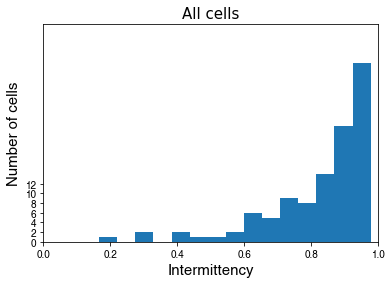

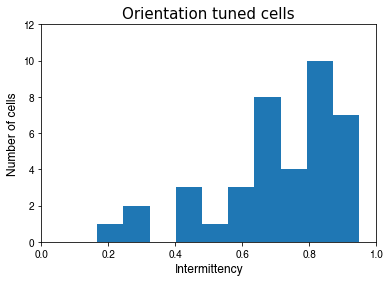

In [155]:
plt.figure()
plt.hist(intermit_pref, bins=15)
plt.xticks(np.round(ax1.get_xticks(),1), fontsize=10, fontname="Helvetica")
plt.yticks(ax1.get_yticks().astype("int"), fontsize=10, fontname="Helvetica")
plt.xlabel("Intermittency", fontsize=fs, fontname="Helvetica")
plt.ylabel("Number of cells", fontsize=fs, fontname="Helvetica")
plt.xlim(0,1)
plt.ylim(0,45)
plt.title("All cells", fontsize=15)
plt.show()

plt.figure()
plt.hist(intermit_pref[tune_all_idx])
plt.xticks(np.round(ax1.get_xticks(),1), fontsize=10, fontname="Helvetica")
plt.yticks(ax1.get_yticks().astype("int"), fontsize=10, fontname="Helvetica")
plt.xlabel("Intermittency", fontsize=12, fontname="Helvetica")
plt.ylabel("Number of cells", fontsize=12, fontname="Helvetica")
plt.xlim(0,1)
plt.ylim(0,12)
plt.title("Orientation tuned cells", fontsize=15)
plt.show()

### In-connection density

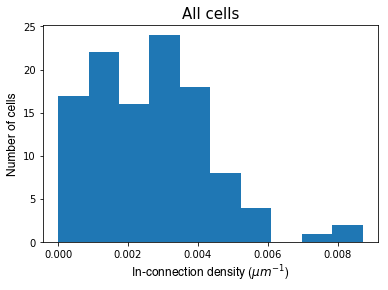

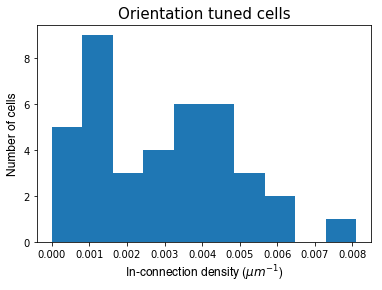

In [154]:
plt.figure()
plt.hist(conn_indens)
plt.xlabel("In-connection density ($\mu m^{-1}$)", fontsize=12, fontname="Helvetica")
plt.ylabel("Number of cells", fontsize=12, fontname="Helvetica")
# plt.xlim(0,1)
# plt.ylim(0,45)
plt.title("All cells", fontsize=15)
plt.show()

plt.figure()
plt.hist(conn_indens[tune_all_idx])
plt.xlabel("In-connection density ($\mu m^{-1}$)", fontsize=12, fontname="Helvetica")
plt.ylabel("Number of cells", fontsize=12, fontname="Helvetica")
# plt.xlim(0,1)
# plt.ylim(0,12)
plt.title("Orientation tuned cells", fontsize=15)
plt.show()

### In-connection density vs. mean response

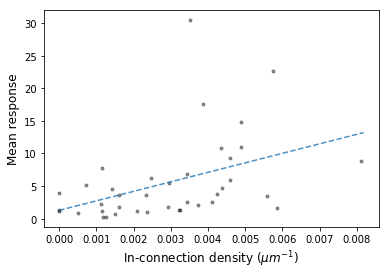

r = 0.4262697665735493, p = 0.0068121908534378795


In [114]:
xval = conn_indens[tune_all_idx]
yval = mean_activity[tune_all_idx]

(m, b, r, p, s) = linregress(xval, yval)

xlin = np.linspace(np.min(xval)*0.99,np.max(xval)*1.01,100)
ylin = xlin*m + b

plt.figure()
plt.plot(xval, yval, 'k.', alpha=0.4)
plt.plot(xlin, ylin, '--', alpha=0.8)
plt.xlabel("In-connection density ($\mu m^{-1}$)", fontsize=12)
plt.ylabel("Mean response", fontsize=12)
plt.show()

r,p = pearsonr(xval, yval)
print("r = {}, p = {}".format(r,p))

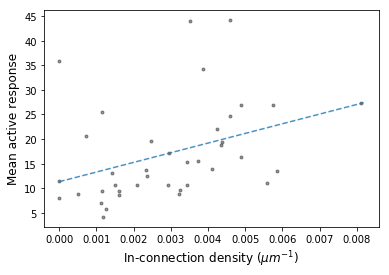

r = 0.3708716281685347, p = 0.02010862340463966


In [116]:
xval = conn_indens[tune_all_idx]
yval = mean_valid_activity[tune_all_idx]

(m, b, r, p, s) = linregress(xval, yval)

xlin = np.linspace(np.min(xval)*0.99,np.max(xval)*1.01,100)
ylin = xlin*m + b

plt.figure()
plt.plot(xval, yval, 'k.', alpha=0.4)
plt.plot(xlin, ylin, '--', alpha=0.8)
plt.xlabel("In-connection density ($\mu m^{-1}$)", fontsize=12)
plt.ylabel("Mean active response", fontsize=12)
plt.show()

r,p = pearsonr(xval, yval)
print("r = {}, p = {}".format(r,p))

### In-connection density vs. intermittency

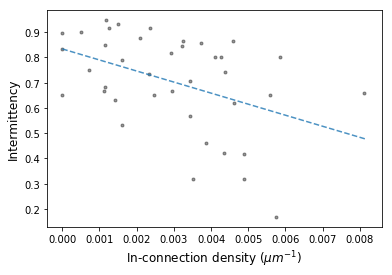

r = -0.432159633358687, p = 0.006007061746413553


In [112]:
xval = conn_indens[tune_all_idx]
yval = intermit_pref[tune_all_idx]

(m, b, r, p, s) = linregress(xval, yval)

xlin = np.linspace(np.min(xval)*0.99,np.max(xval)*1.01,100)
ylin = xlin*m + b

plt.figure()
plt.plot(xval, yval, 'k.', alpha=0.4)
plt.plot(xlin, ylin, '--', alpha=0.8)
plt.xlabel("In-connection density ($\mu m^{-1}$)", fontsize=12)
plt.ylabel("Intermittency", fontsize=12)
plt.show()

r,p = pearsonr(xval, yval)
print("r = {}, p = {}".format(r,p))

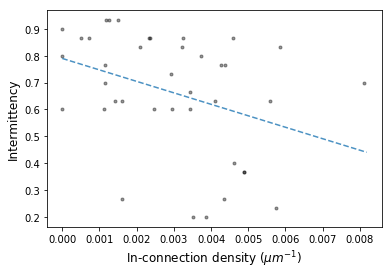

r = -0.35933920837121897, p = 0.024659655365127688


In [157]:
xval = conn_indens[tune_all_idx]
yval = intermit_max[tune_all_idx]

(m, b, r, p, s) = linregress(xval, yval)

xlin = np.linspace(np.min(xval)*0.99,np.max(xval)*1.01,100)
ylin = xlin*m + b

plt.figure()
plt.plot(xval, yval, 'k.', alpha=0.4)
plt.plot(xlin, ylin, '--', alpha=0.8)
plt.xlabel("In-connection density ($\mu m^{-1}$)", fontsize=12)
plt.ylabel("Intermittency", fontsize=12)
plt.show()

r,p = pearsonr(xval, yval)
print("r = {}, p = {}".format(r,p))

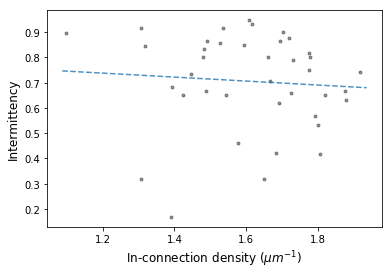

r = -0.07676691944923551, p = 0.6422910345091654


In [180]:
xval = syn_indens_all[tune_all_idx]
yval = intermit_pref[tune_all_idx]

(m, b, r, p, s) = linregress(xval, yval)

xlin = np.linspace(np.min(xval)*0.99,np.max(xval)*1.01,100)
ylin = xlin*m + b

plt.figure()
plt.plot(xval, yval, 'k.', alpha=0.4)
plt.plot(xlin, ylin, '--', alpha=0.8)
plt.xlabel("In-connection density ($\mu m^{-1}$)", fontsize=12)
plt.ylabel("Intermittency", fontsize=12)
plt.show()

r,p = pearsonr(xval, yval)
print("r = {}, p = {}".format(r,p))

### Permutation test

#### Intermittency

In [60]:
xval = intermit_pref[tune_all_idx]
yval = conn_indens[tune_all_idx]

T = 10000
rand_int = np.zeros((T,))
for t in range(T):
    
    int_shuffled = np.copy(xval)
    np.random.shuffle(int_shuffled)
    
    r, p = pearsonr(int_shuffled, yval)
    rand_int[t] = r

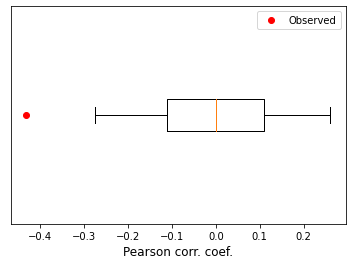

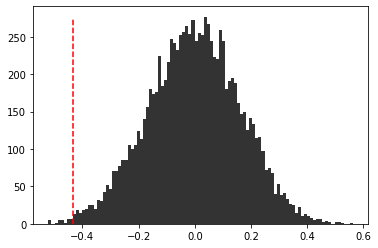

In [61]:
r_true_int, p_true_int = pearsonr(conn_indens[tune_all_idx], intermit_pref[tune_all_idx])

plt.figure()
plt.boxplot(rand_int, sym="", whis=[5,95], vert=False)
plt.plot(r_true_int, 1, "r.", markersize=12, label="Observed")
plt.yticks([])
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.hist(rand_int, bins=100, color="k", alpha=0.8)
plt.vlines(r_true_int, 0, 275, linestyle="--", color="r")
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.show()

#### Mean response

In [41]:
xval = mean_activity[tune_all_idx]
yval = conn_indens[tune_all_idx]

T = 10000
rand_act = np.zeros((T,))
for t in range(T):
    
    act_shuffled = np.copy(xval)
    np.random.shuffle(act_shuffled)
    
    r, p = pearsonr(act_shuffled, yval)
    rand_act[t] = r

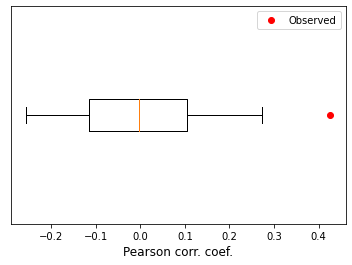

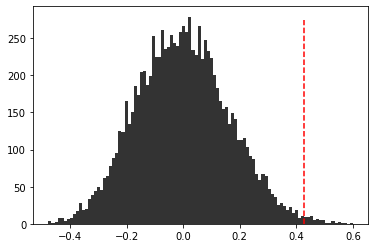

In [53]:
r_true_act, p_true_act = pearsonr(conn_indens[tune_all_idx], mean_activity[tune_all_idx])

plt.figure()
plt.boxplot(rand_act, sym="", whis=[5,95], vert=False)
plt.plot(r_true_act, 1, "r.", markersize=12, label="Observed")
plt.yticks([])
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.hist(rand_act, bins=100, color="k", alpha=0.8)
plt.vlines(r_true_act, 0, 275, linestyle="--", color="r")
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.show()

In [54]:
xval = mean_valid_activity[tune_all_idx]
yval = conn_indens[tune_all_idx]

T = 10000
rand_act_resp = np.zeros((T,))
for t in range(T):
    
    act_shuffled = np.copy(xval)
    np.random.shuffle(act_shuffled)
    
    r, p = pearsonr(act_shuffled, yval)
    rand_act_resp[t] = r

#### Mean active response

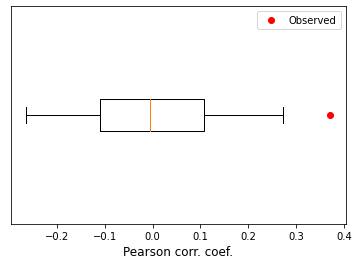

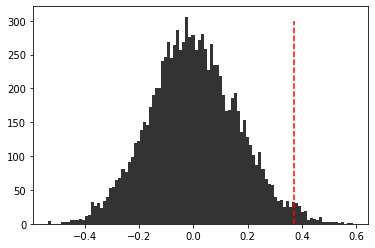

In [59]:
r_true_act_resp, p_true_act_resp = pearsonr(conn_indens[tune_all_idx], mean_valid_activity[tune_all_idx])

plt.figure()
plt.boxplot(rand_act_resp, sym="", whis=[5,95], vert=False)
plt.plot(r_true_act_resp, 1, "r.", markersize=12, label="Observed")
plt.yticks([])
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.hist(rand_act_resp, bins=100, color="k", alpha=0.8)
plt.vlines(r_true_act_resp, 0, 300, linestyle="--", color="r")
plt.show()

## Figure 6

In [28]:
fs = 18

def plot_trace_dir(ax, seg_id, angle, xlab="", ylab=""):
    
    scan_id = scan_ease[seg_id_ease==seg_id][0]
    
    trace = extract_ease(pinky, seg_id, scan_id, "trace_raw")
    con = np.round((pinky.Stimulus() & {"scan_id": scan_id}).fetch1("condition"), 1)

    section_list = get_section(con, angle)

    for s in section_list:
        n = s[1] - s[0] + 1
        plt.plot(np.arange(0,n*0.0674-0.001,0.0674), trace[s[0]:s[1]+1], linewidth=0.5)

    ax.set_xlim(0,1)
    ax.set_xticks(np.arange(0,1.1,0.5))
    ax.set_xticklabels(np.round(ax.get_xticks(),1), fontsize=15, fontname="Helvetica")
    ax.set_yticklabels(ax.get_yticks().astype("int"), fontsize=15, fontname="Helvetica")
    ax.set_xlabel(xlab, fontsize=fs, fontname="Helvetica")
    ax.set_ylabel(ylab, fontsize=fs, fontname="Helvetica")
    
    
def plot_linfit(ax, xval, yval, xlab="Intermittency", ylab="In-connection density ($\mu m^{-1}$)"):
    
    (m, b, r, p, s) = linregress(xval, yval)

    xlin = np.linspace(xval.min()*0.95,xval.max()*1.05,100)
    ylin = xlin*m + b

    bins = np.linspace(xval.min(),xval.max()*1.001,5)
    binsize = bins[1]-bins[0]
    nbins = bins.shape[0]-1
    center = np.zeros(nbins)
    err = np.zeros(nbins)
    for i in range(nbins):

        valid = (xval>=bins[i])*(xval<bins[i+1])
        bin_val = yval[valid]

        if np.sum(valid)==0:
            continue

        center[i] = np.mean(bin_val)
        err[i] = np.std(bin_val)/bin_val.shape[0]**0.5

    valid = center!=0
    bins_valid = bins[:-1][valid]
    center_valid = center[valid]
    err_valid = err[valid]

    palette = sns.color_palette("colorblind")
    ax.plot(xval, yval, 'k.', alpha=0.2)
    ax.plot(xlin, ylin, 'k--', alpha=0.8, label="linear fit")
    
    ax.set_xlabel(xlab, fontsize=fs, fontname="Helvetica")
    ax.set_ylabel(ylab, fontsize=fs, fontname="Helvetica")

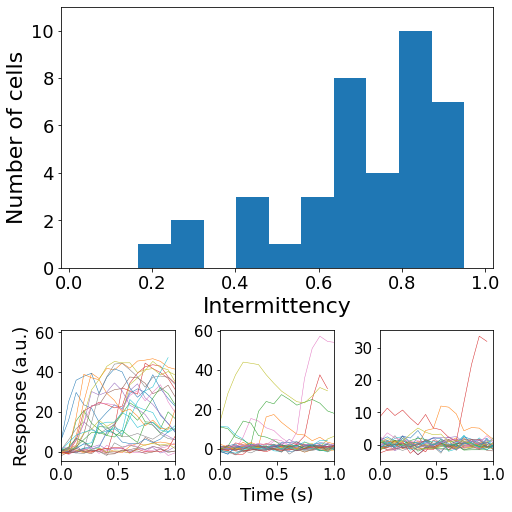

In [94]:
fig = plt.figure(figsize=(7,7), constrained_layout=True)
gs = fig.add_gridspec(6,6)

ax1 = fig.add_subplot(gs[:4,:6])
h = ax1.hist(intermit_pref[tune_all_idx], bins=10)
ax1.set_xlim(-0.02, 1.02)
ax1.set_ylim(0,11)
ax1.set_xticklabels(np.round(ax1.get_xticks(),1), fontsize=18, fontname="Helvetica")
ax1.set_yticklabels(ax1.get_yticks().astype("int"), fontsize=18, fontname="Helvetica")
ax1.set_xlabel("Intermittency", fontsize=22, fontname="Helvetica")
ax1.set_ylabel("Number of cells", fontsize=22, fontname="Helvetica")

# Example cells
ax2 = fig.add_subplot(gs[4:6,:2])
plot_trace_dir(ax2, 648518346349537961, 315, xlab="", ylab="Response (a.u.)")
ylim = list(ax2.get_ylim())
ylim[1] = 61
ax2.set_ylim(ylim)

ax3 = fig.add_subplot(gs[4:6,2:4])
plot_trace_dir(ax3, 648518346349532006, 180, xlab="Time (s)")

ax4 = fig.add_subplot(gs[4:6,4:6])
plot_trace_dir(ax4, 648518346349539834, 270, xlab="")

plt.savefig("figures/fig4_plots_part1.svg")
plt.show()

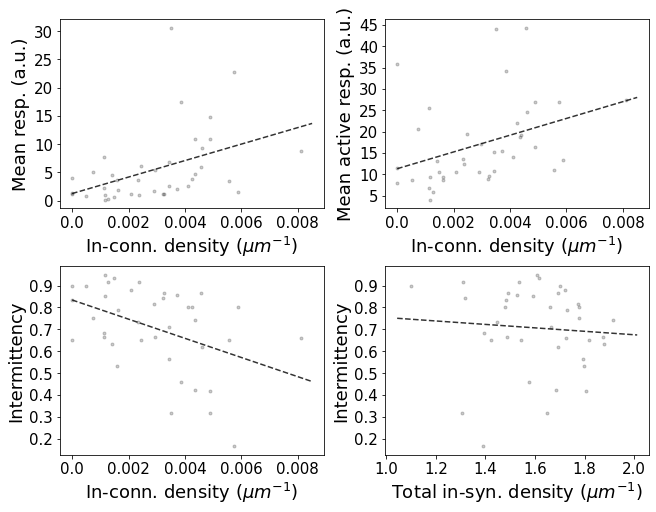

In [23]:
fig = plt.figure(figsize=(9,7), constrained_layout=True)
gs = fig.add_gridspec(6,6)

ax5 = fig.add_subplot(gs[:3,:3])
plot_linfit(ax5, conn_indens[tune_all_idx], mean_response[tune_all_idx], xlab="In-conn. density ($\mu m^{-1}$)", ylab="Mean resp. (a.u.)")
ax5.set_xticklabels(np.round(ax5.get_xticks(),3), fontsize=15, fontname="Helvetica")
ax5.set_yticklabels(ax5.get_yticks().astype("int"), fontsize=15, fontname="Helvetica")

ax6 = fig.add_subplot(gs[:3,3:6])
plot_linfit(ax6, conn_indens[tune_all_idx], mean_active_response[tune_all_idx], xlab="In-conn. density ($\mu m^{-1}$)", ylab="Mean active resp. (a.u.)")
ax6.set_xticklabels(np.round(ax6.get_xticks(),3), fontsize=15, fontname="Helvetica")
ax6.set_yticklabels(ax6.get_yticks().astype("int"), fontsize=15, fontname="Helvetica")
    
ax7 = fig.add_subplot(gs[3:,:3])
plot_linfit(ax7, conn_indens[tune_all_idx], intermit_pref[tune_all_idx], xlab="In-conn. density ($\mu m^{-1}$)", ylab="Intermittency")
ax7.set_xticklabels(np.round(ax7.get_xticks(),3), fontsize=15, fontname="Helvetica")
ax7.set_yticklabels(np.round(ax7.get_yticks(),1), fontsize=15, fontname="Helvetica")

ax8 = fig.add_subplot(gs[3:,3:6])
plot_linfit(ax8, syn_indens_all[tune_all_idx], intermit_pref[tune_all_idx], xlab="Total in-syn. density ($\mu m^{-1}$)", ylab="Intermittency")
ax8.set_xticklabels(np.round(ax8.get_xticks(),2), fontsize=15, fontname="Helvetica")
ax8.set_yticklabels(np.round(ax8.get_yticks(),1), fontsize=15, fontname="Helvetica")

plt.savefig("figures/fig4_plots_part2.svg")
plt.show()

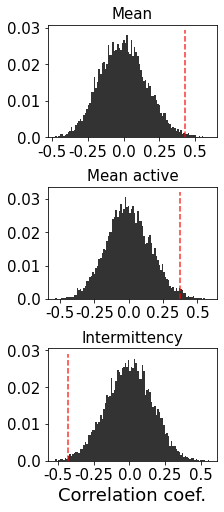

In [81]:
fig = plt.figure(figsize=(3,7), constrained_layout=True)
gs = fig.add_gridspec(3,1)

ax9 = fig.add_subplot(gs[:1,0])
ax9.hist(rand_act, bins=100, color="k", alpha=0.8)
ax9.vlines(r_true_act, ax9.get_ylim()[0], ax9.get_ylim()[1], color="r", linestyle="--", alpha=0.8)
ax9.set_xticklabels(np.round(ax9.get_xticks(),2), fontsize=15, fontname="Helvetica")
ax9.set_yticklabels(np.round((ax9.get_yticks()/10000),2), fontsize=15, fontname="Helvetica")
ax9.set_title("Mean", fontsize=15, fontname="Helvetica")

ax10 = fig.add_subplot(gs[1:2,0])
ax10.hist(rand_act_resp, bins=100, color="k", alpha=0.8)
ax10.vlines(r_true_act_resp, ax10.get_ylim()[0], ax10.get_ylim()[1], color="r", linestyle="--", alpha=0.8)
ax10.set_xticklabels(np.round(ax10.get_xticks(),2), fontsize=15, fontname="Helvetica")
ax10.set_yticklabels(np.round((ax10.get_yticks()/10000),2), fontsize=15, fontname="Helvetica")
ax10.set_title("Mean active", fontsize=15, fontname="Helvetica")

ax11 = fig.add_subplot(gs[2:,0])
ax11.hist(rand_int, bins=100, color="k", alpha=0.8)
ax11.vlines(r_true_int, ax11.get_ylim()[0], ax11.get_ylim()[1], color="r", linestyle="--", alpha=0.8)
ax11.set_xticklabels(np.round(ax11.get_xticks(),2), fontsize=15, fontname="Helvetica")
ax11.set_yticklabels(np.round((ax11.get_yticks()/10000),2), fontsize=15, fontname="Helvetica")
ax11.set_xlabel("Correlation coef.", fontsize=18, fontname="Helvetica")
ax11.set_title("Intermittency", fontsize=15, fontname="Helvetica")

plt.savefig("figures/fig4_plots_part4.svg")
plt.show()